In [1]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
3.14.4


In [2]:
#f_nc_delta_run1 = uproot.open("data/processed_checkout_rootfiles/checkout_prodgenie_bnb_nc_delta_overlay_run1_PF.root")["wcpselection"]
#print(f_nc_delta_run1.keys())
#f_nc_delta_run1["T_PFeval"].show()

In [3]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [4]:
extra_bdt_variables = [
    "nue_score",
    "numu_score"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum"
]

pf_eval_data_variables_no_pf_info = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]

# these are the variables that get loaded from the T_BDTvars tree. Doesn't include nc_delta_score since that isn't available
# in the isotropic file
bdt_vars = extra_bdt_variables


In [5]:
wc_file_location = "/data1/hagaman/xin_files/processed_checkout_rootfiles/" # training events removed

In [6]:
# loading WC nue overlay files

f_intrinsic_nue_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run1_PF.root")["wcpselection"]
f_intrinsic_nue_run1_bdt = f_intrinsic_nue_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run1_eval = f_intrinsic_nue_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run1_pfeval = f_intrinsic_nue_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run1_kine = f_intrinsic_nue_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run1_pot = f_intrinsic_nue_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run1_file_POT = np.sum(f_intrinsic_nue_run1_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run1_df = pd.concat([f_intrinsic_nue_run1_bdt, f_intrinsic_nue_run1_eval, f_intrinsic_nue_run1_pfeval, f_intrinsic_nue_run1_kine], axis=1, sort=False)
del f_intrinsic_nue_run1
del f_intrinsic_nue_run1_bdt
del f_intrinsic_nue_run1_eval
del f_intrinsic_nue_run1_pfeval
del f_intrinsic_nue_run1_kine
del f_intrinsic_nue_run1_pot
intrinsic_nue_run1_df["isEXT"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["isDirt"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["WC_file"] = ["intrinsic_nue_run1" for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["run_num"] = [1 for i in range(intrinsic_nue_run1_df.shape[0])]

print(intrinsic_nue_run1_file_POT)
print(intrinsic_nue_run1_df.shape[0])

f_intrinsic_nue_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run2_PF.root")["wcpselection"]
f_intrinsic_nue_run2_bdt = f_intrinsic_nue_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run2_eval = f_intrinsic_nue_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run2_pfeval = f_intrinsic_nue_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run2_kine = f_intrinsic_nue_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run2_pot = f_intrinsic_nue_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run2_file_POT = np.sum(f_intrinsic_nue_run2_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run2_df = pd.concat([f_intrinsic_nue_run2_bdt, f_intrinsic_nue_run2_eval, f_intrinsic_nue_run2_pfeval, f_intrinsic_nue_run2_kine], axis=1, sort=False)
del f_intrinsic_nue_run2
del f_intrinsic_nue_run2_bdt
del f_intrinsic_nue_run2_eval
del f_intrinsic_nue_run2_pfeval
del f_intrinsic_nue_run2_kine
del f_intrinsic_nue_run2_pot
intrinsic_nue_run2_df["isEXT"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["isDirt"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["WC_file"] = ["intrinsic_nue_run2" for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["run_num"] = [2 for i in range(intrinsic_nue_run2_df.shape[0])]

print(intrinsic_nue_run2_file_POT)
print(intrinsic_nue_run2_df.shape[0])

f_intrinsic_nue_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run3_PF.root")["wcpselection"]
f_intrinsic_nue_run3_bdt = f_intrinsic_nue_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run3_eval = f_intrinsic_nue_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run3_pfeval = f_intrinsic_nue_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run3_kine = f_intrinsic_nue_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run3_pot = f_intrinsic_nue_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run3_file_POT = np.sum(f_intrinsic_nue_run3_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run3_df = pd.concat([f_intrinsic_nue_run3_bdt, f_intrinsic_nue_run3_eval, f_intrinsic_nue_run3_pfeval, f_intrinsic_nue_run3_kine], axis=1, sort=False)
del f_intrinsic_nue_run3
del f_intrinsic_nue_run3_bdt
del f_intrinsic_nue_run3_eval
del f_intrinsic_nue_run3_pfeval
del f_intrinsic_nue_run3_kine
del f_intrinsic_nue_run3_pot
intrinsic_nue_run3_df["isEXT"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["isDirt"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["WC_file"] = ["intrinsic_nue_run3" for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["run_num"] = [3 for i in range(intrinsic_nue_run3_df.shape[0])]

print(intrinsic_nue_run3_file_POT)
print(intrinsic_nue_run3_df.shape[0])

intrinsic_nue_df = pd.concat([intrinsic_nue_run1_df, intrinsic_nue_run2_df, intrinsic_nue_run3_df], sort=False).query(
    "truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0")

del intrinsic_nue_run1_df
del intrinsic_nue_run2_df
del intrinsic_nue_run3_df


3.931094470783121e+22
68206
1.2460289446544576e+23
209160
8.821478522260567e+22
148962


In [7]:
# loading WC nu overlay files

f_nu_overlay_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False).query(
    "not (truth_isCC==1 and abs(truth_nuPdg)==12) and kine_reco_Enu > 0")
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df

In [8]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

numu_and_nue_df = pd.concat([overlay_df, intrinsic_nue_df], sort=False)

del overlay_df
del intrinsic_nue_df


In [9]:
# adding truth primary particle nums, only for numu and nue

num_prim_photons = []
num_prim_protons = []
num_prim_charged_pions = []
num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []
num_prim_pi0s = []
num_prim_others = []

max_proton_true_kinetic_energies = []
max_pion_true_kinetic_energies = []

photon_thetas = []
photon_phis = []
photon_energies = []

runnum = numu_and_nue_df["run_num"].to_numpy()
run = numu_and_nue_df["run"].to_numpy()
subrun = numu_and_nue_df["subrun"].to_numpy()
event = numu_and_nue_df["event"].to_numpy()

truth_pdgs = numu_and_nue_df["truth_pdg"].to_numpy()
truth_mothers = numu_and_nue_df["truth_mother"].to_numpy()
truth_startMomentums = numu_and_nue_df["truth_startMomentum"].to_numpy()

for i in tqdm(range(numu_and_nue_df.shape[0])):

    num_prim_photon = 0
    num_prim_proton = 0
    num_prim_charged_pion = 0
    num_prim_neutron = 0
    num_prim_electron = 0
    num_prim_muon = 0
    num_prim_pi0 = 0
    num_prim_other = 0
    
    max_pion_true_kinetic_energy = 0
    max_proton_true_kinetic_energy = 0

    photon_theta = np.nan
    photon_phi = np.nan
    photon_energy = np.nan
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]

    for j in range(len(truth_pdg_list)):

        photon_angle_found = False

        if truth_mother_list[j] != 0: # non-primary
            continue
        if abs(truth_pdg_list[j]) == 12 or abs(truth_pdg_list[j]) == 14: # primary neutrino (exiting NC interaction)
            continue
        elif truth_pdg_list[j] == 22:
            num_prim_photon += 1

            if not photon_angle_found:

                photon_4_momentum = truth_startMomentum_list[j]

                if photon_4_momentum[3] > 0:
                    photon_momentum_perp = np.sqrt(photon_4_momentum[0] * photon_4_momentum[0] + photon_4_momentum[1] * photon_4_momentum[1])
                    photon_theta = np.arctan2(photon_momentum_perp, photon_4_momentum[2]) * 180. / np.pi
                    photon_phi = np.arctan2(photon_4_momentum[0], photon_4_momentum[1]) * 180. / np.pi
                    photon_energy = photon_4_momentum[3] * 1000.

                photon_angle_found = True

        elif truth_pdg_list[j] == 2212:
            num_prim_proton += 1
            
            proton_kinetic_energy = 1000. * truth_startMomentum_list[j][3] - 938.272
            max_proton_true_kinetic_energy = max(max_proton_true_kinetic_energy, proton_kinetic_energy)
            
        elif abs(truth_pdg_list[j]) == 211:
            num_prim_charged_pion += 1
            
            pion_kinetic_energy = 1000. * truth_startMomentum_list[j][3] - 139.570
            max_pion_true_kinetic_energy = max(max_pion_true_kinetic_energy, pion_kinetic_energy)
            
        elif truth_pdg_list[j] == 2112:
            num_prim_neutron += 1
        elif abs(truth_pdg_list[j]) == 11:
            num_prim_electron += 1
        elif abs(truth_pdg_list[j]) == 13:
            num_prim_muon += 1
        elif truth_pdg_list[j] == 111:
            num_prim_pi0 += 1
        else:
            num_prim_other += 1
            #print(truth_pdg_list[j])


    num_prim_photons.append(num_prim_photon)
    num_prim_protons.append(num_prim_proton)
    num_prim_charged_pions.append(num_prim_charged_pion)
    num_prim_neutrons.append(num_prim_neutron)
    num_prim_electrons.append(num_prim_electron)
    num_prim_muons.append(num_prim_muon)
    num_prim_pi0s.append(num_prim_pi0)
    num_prim_others.append(num_prim_other)
    
    max_proton_true_kinetic_energies.append(max_proton_true_kinetic_energy)
    max_pion_true_kinetic_energies.append(max_pion_true_kinetic_energy)

    photon_thetas.append(photon_theta)
    photon_phis.append(photon_phi)
    photon_energies.append(photon_energy)

numu_and_nue_df["num_prim_photons"] = num_prim_photons
numu_and_nue_df["num_prim_protons"] = num_prim_protons
numu_and_nue_df["num_prim_charged_pions"] = num_prim_charged_pions
numu_and_nue_df["num_prim_neutrons"] = num_prim_neutrons
numu_and_nue_df["num_prim_electrons"] = num_prim_electrons
numu_and_nue_df["num_prim_muons"] = num_prim_muons
numu_and_nue_df["num_prim_pi0s"] = num_prim_pi0s
numu_and_nue_df["num_prim_others"] = num_prim_others

numu_and_nue_df["max_proton_true_kinetic_energy"] = max_proton_true_kinetic_energies
numu_and_nue_df["max_pion_true_kinetic_energy"] = max_pion_true_kinetic_energies

numu_and_nue_df["prim_photon_theta"] = photon_thetas
numu_and_nue_df["prim_photon_phi"] = photon_phis
numu_and_nue_df["prim_photon_energy"] = photon_energies


100%|█████████████████████████| 973577/973577 [02:27<00:00, 6610.01it/s]


In [10]:
# loading WC EXT files

# run3 POT info is missing for PF files! using non-pf versions for now.

#f_ext_run1 = uproot.open(wc_file_location + "checkout_data_extbnb_run1_PF.root")["wcpselection"]
f_ext_run1 = uproot.open(wc_file_location + "wcp_data_extbnb_run1_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run1
del f_ext_run1_bdt
del f_ext_run1_eval
del f_ext_run1_pfeval
del f_ext_run1_kine
del f_ext_run1_pot
ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

f_ext_run2 = uproot.open(wc_file_location + "wcp_data_extbnb_run2_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run2
del f_ext_run2_bdt
del f_ext_run2_eval
del f_ext_run2_pfeval
del f_ext_run2_kine
del f_ext_run2_pot
ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

f_ext_run3 = uproot.open(wc_file_location + "wcp_data_extbnb_run3_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run3
del f_ext_run3_bdt
del f_ext_run3_eval
del f_ext_run3_pfeval
del f_ext_run3_kine
del f_ext_run3_pot
ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

print(ext_run1_POT, ext_run2_POT, ext_run3_POT)
print(ext_run1_df.shape[0], ext_run2_df.shape[0], ext_run3_df.shape[0])

ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False)
del ext_run1_df
del ext_run2_df
del ext_run3_df



4.077658562050436e+263 7.178643762897787e+291 2.3038218475231197e+306
9977 28092 33019


In [11]:
# loading WC dirt files

f_dirt_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
del f_dirt_run1
del f_dirt_run1_bdt
del f_dirt_run1_eval
del f_dirt_run1_pfeval
del f_dirt_run1_kine
del f_dirt_run1_pot
dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

f_dirt_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
del f_dirt_run2
del f_dirt_run2_bdt
del f_dirt_run2_eval
del f_dirt_run2_pfeval
del f_dirt_run2_kine
del f_dirt_run2_pot
dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

f_dirt_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
del f_dirt_run3
del f_dirt_run3_bdt
del f_dirt_run3_eval
del f_dirt_run3_pfeval
del f_dirt_run3_kine
del f_dirt_run3_pot
dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]

dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False).query("kine_reco_Enu > 0")
del dirt_run1_df
del dirt_run2_df
del dirt_run3_df

In [12]:
# full data

em_charge_scale = 0.95

f_data_run1 = uproot.open(wc_file_location + "checkout_data_bnb_run1_PF.root")["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine
data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["WC_file"] = ["data_run1" for i in range(data_run1_df.shape[0])]
data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

f_data_run2 = uproot.open(wc_file_location + "checkout_data_bnb_run2_PF.root")["wcpselection"]
f_data_run2_bdt = f_data_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run2_eval = f_data_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run2_pfeval = f_data_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run2_kine = f_data_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run2_df = pd.concat([f_data_run2_bdt, f_data_run2_eval, f_data_run2_pfeval, f_data_run2_kine], axis=1, sort=False)
del f_data_run2
del f_data_run2_bdt
del f_data_run2_eval
del f_data_run2_pfeval
del f_data_run2_kine
data_run2_df["isEXT"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["isDirt"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["WC_file"] = ["data_run2" for i in range(data_run2_df.shape[0])]
data_run2_df["category"] = ["data" for i in range(data_run2_df.shape[0])]
data_run2_df["run_num"] = [2 for i in range(data_run2_df.shape[0])]

f_data_run3 = uproot.open(wc_file_location + "checkout_data_bnb_run3_PF.root")["wcpselection"]
f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
del f_data_run3
del f_data_run3_bdt
del f_data_run3_eval
del f_data_run3_pfeval
del f_data_run3_kine
data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["WC_file"] = ["data_run3" for i in range(data_run3_df.shape[0])]
data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]


data_all_df = pd.concat([data_run1_df, data_run2_df, data_run3_df], sort=False).query("kine_reco_Enu > 0")

del data_run1_df
del data_run2_df
del data_run3_df

In [13]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

all_df = pd.concat([numu_and_nue_df, ext_df, dirt_df], sort=False)

del numu_and_nue_df
del ext_df
del dirt_df


In [14]:
normalizing_POT_run1 = 1.423e20
normalizing_POT_run2 = 2.541e20
normalizing_POT_run3 = 2.405e20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)
truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()


run_nums = all_df["run_num"].to_numpy()
WC_file_str = all_df["WC_file"].to_numpy()
net_weights = []
for i in tqdm(range(len(weight_cv))):
    weight_temp = weight_cv[i] * weight_spline[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
        weight_temp = 1.
    if run_nums[i] == 1:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run1 / ext_run1_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run1 / dirt_run1_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run1 / intrinsic_nue_run1_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run1 / nu_overlay_run1_POT)
    elif run_nums[i] == 2:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run2 / ext_run2_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run2 / dirt_run2_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run2 / intrinsic_nue_run2_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run2 / nu_overlay_run2_POT)
    elif run_nums[i] == 3:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run3 / ext_run3_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run3 / dirt_run3_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run3 / intrinsic_nue_run3_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run3 / nu_overlay_run3_POT)
            
all_df["net_weight"] = net_weights

100%|█████████████████████| 1075811/1075811 [00:06<00:00, 154565.58it/s]


In [15]:
true_nue_FC_df = all_df.query("not (isDirt==1) and not (isEXT==1) and truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0 and nue_score > 7 and match_isFC==1")

true_nue_PC_df = all_df.query("not (isDirt==1) and not (isEXT==1) and truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0 and nue_score > 7 and match_isFC==0")


In [16]:
b = (60, 60)
r = ((0, 3000), (0, 3000))

remade_res_FC_raw, xedges_, yedges_ = np.histogram2d(true_nue_FC_df["truth_nuEnergy"].to_numpy(), true_nue_FC_df["kine_reco_Enu"].to_numpy(), weights=true_nue_FC_df["net_weight"].to_numpy(), bins=b, range=r)
remade_res_PC_raw, xedges_, yedges_ = np.histogram2d(true_nue_PC_df["truth_nuEnergy"].to_numpy(), true_nue_PC_df["kine_reco_Enu"].to_numpy(), weights=true_nue_PC_df["net_weight"].to_numpy(), bins=b, range=r)


In [17]:
nueCC_FC_res = []
nueCC_PC_res = []
for i in range(60):
    for j in range(60):
        nueCC_FC_res.append(remade_res_FC_raw[i][j])
        nueCC_PC_res.append(remade_res_PC_raw[i][j])

bin_centers_x = []
bin_centers_y = []
for i in range(60):
    for j in range(60):
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)
        
b = (60, 60)
r = ((0, 3000), (0, 3000))

In [19]:
print(np.max(nueCC_FC_res), np.max(nueCC_PC_res))

1.672655336106101 0.5388897967135103


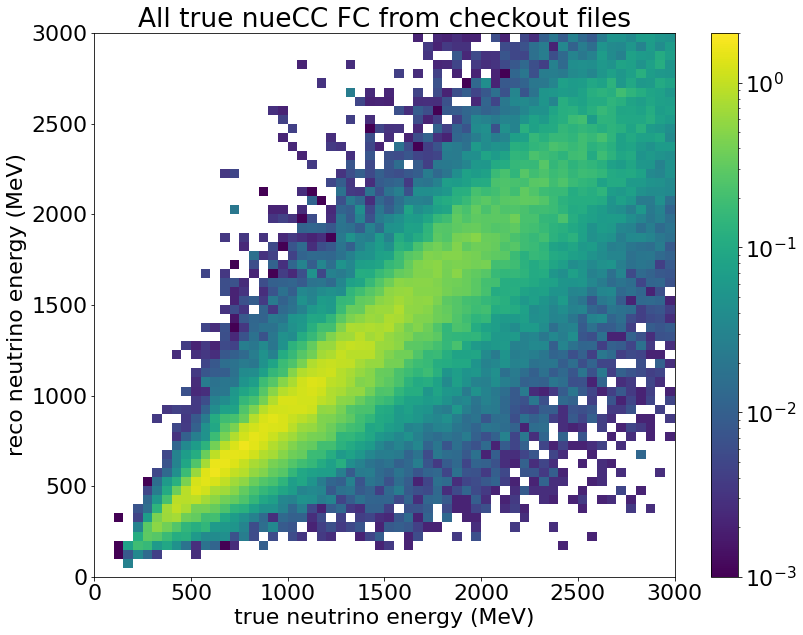

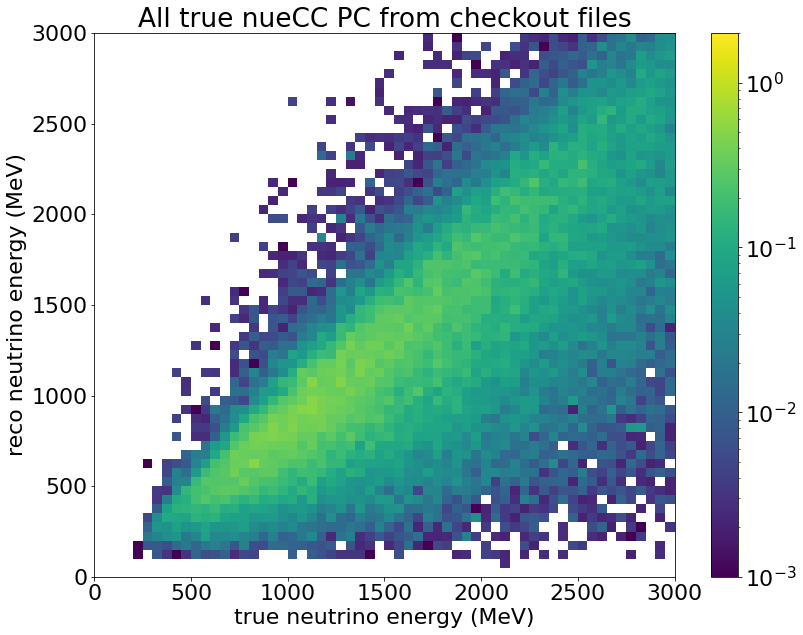

In [20]:
mpl.rcParams.update({'font.size': 22})

plt.figure(figsize=(13,10))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_FC_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy (MeV)")
plt.ylabel("reco neutrino energy (MeV)")
plt.title("All true nueCC FC from checkout files")
plt.show()

plt.figure(figsize=(13,10))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_PC_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy (MeV)")
plt.ylabel("reco neutrino energy (MeV)")
plt.title("All true nueCC PC from checkout files")
plt.show()